# CSAIL Data

In [72]:
#nbx --fname="src/csail_data.jl"
import JSON
const slam_data_keys = ["z", "a", "x", "hd", "dx", "dhd"] 

"""
    d::Dict = load_sensor_data(fname)

Loads sensor data json. Assumes/requires that the json 
contains keys: `z`, `a`, `x`, `hd`, `dx`, and `dhd`.
"""
function load_sensor_data(fname)
    d′  = JSON.parsefile(fname)
    d = Dict()
    for k in slam_data_keys
        d[k] = [Float64.(x) for x in d′[k]]
    end
    return d
end

load_sensor_data

In [73]:
#nbx
push!(LOAD_PATH, "../src");
using GridSlam: Pose, Measurement, Control
using MyUtils: polar_inv
fname = "../data/mit-csail.json"
d = load_sensor_data(fname);

In [77]:
#nbx
_zs = d["z"]
_zmax = maximum(maximum.(_zs))
for i=1:length(_zs)
    z = _zs[i]
    _zs[i][z.==_zmax] .= Inf
end
_zmax = Inf
_as = d["a"]
_ys = [polar_inv(z,_as) for z in _zs];

_xs   = d["x"]
_hds  = d["hd"]
_ps   = [Pose(x,hd) for (x,hd) in zip(_xs, _hds)]

_dxs  = d["dx"]
_dhds = d["dhd"]
_us   = [Control(dx,dhd) for (dx,dhd) in zip(_dxs, _dhds)]

_T    = length(_zs)
_num_a = length(_as)

println("Loading `$(fname)` ...\n")
for x in [:_zs, :_as, :_zmax, :_ys, :_num_a, :_xs, :_hds, :_ps, :_dxs, :_dhds, :_us, :_T]
    local y = getproperty(Main,x)
    println("\t$(x) \t$(typeof(y))")
end

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


In [51]:
using BenchmarkTools;
using Colors, Plots;
using Interact
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));

WebIO._IJuliaInit()

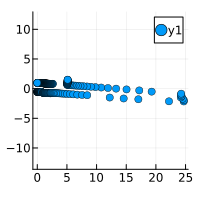

In [52]:
t = 1050
# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(_ys[t])

In [69]:
ani = Animation()

@manipulate for t=slider(1:2:_T, value=1_040, label="t")
    plot(size=(400,400), aspect_ratio=:equal, xlim=(-2,20), ylim=(-10,10))
    scatter!(_ys[t])
    scatter!([0],[0], c=:red, marker=:o, markerstrokewidth=0,)
    scatter!([1],[0], c=:red, marker=:x)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 994, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(521), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/ubuntu/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/ubuntu/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/ubuntu/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/home/ubuntu/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/home/ubuntu/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f6b72e5fde0, Task (runnable) @0x00007f6b72e5fde0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"3\",\"5\",\"7\",\"9\",\"11\",\"13\",\"15\",\"17\",\"19\",\"21\",\"23\",\"25\",\"27\",\"29\",\"31\",\"33\",\"35\",\"37\",\"39\",\"41\",\"43\",\"45\",\"47\",\"49\",\"51\",\"53\",\"55\",\"57\",\"59\",\"61\",\"63\",\"65\",\"67\",\"69\",\"71\",\"73\",\"75\",\"77\",\"79\",\"81\",\"83\",\"85\",\"87\",\"89\",\"91\",\"93\",\"95\",\"97\",\"99